In [20]:
import torch
import torchvision 
import torchaudio
import random
import librosa.display

import pandas as pd
import numpy as np
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from tqdm.notebook import tqdm
import IPython.display as display
import torchvision.transforms as T

%matplotlib inline

In [21]:
# data_path = './genres/'
# cmap = plt.get_cmap('inferno')
# plt.figure(figsize=(8, 8))
# genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# for g in genres:
#   pathlib.Path(f'./data/image_data/{g}').mkdir(parents = True, exist_ok = True)
#   for filename in os.listdir(f'{data_path}/{g}'):
#     songname = f'{data_path}/{g}/{filename}'
#     y, sr = librosa.load(songname, mono = True, duration = 5)
#     plt.specgram(y, NFFT = 2048, Fs=2, Fc=0, noverlap = 128, cmap = cmap,sides = 'default', mode = 'default', scale = 'dB')
#     plt.axis('off')
#     plt.savefig(f'./data/image_data/{g}/{filename[:-3].replace(".", "")}.png')
#     plt.clf()

In [22]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # set True to be faster
    print(f'Setting all seeds to be {seed} to reproduce...')
seed_everything(42)

Setting all seeds to be 42 to reproduce...


In [23]:
img_path = './data/image_data/'
batch_size = 32
image_size = 224

train_trfms = T.Compose([
                         T.Resize(image_size),
                         T.RandomRotation(20),
                         T.RandomHorizontalFlip(),
                         T.ToTensor()
])

val_trfms = T.Compose([
                       T.Resize(image_size),
                       T.ToTensor()
])

In [24]:
train_data = torchvision.datasets.ImageFolder(root = img_path,transform =  train_trfms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trfms)

In [25]:
def Encode(data):
  classes = data.classes
  encoder = {}
  for i in range(len(classes)):
    encoder[i] = classes[i]
  return encoder

def Decoder(data):
  classes = data.classes

  decoder = {}
  for i in range(len(classes)):
    decoder[classes[i]] = i
  return decoder

In [26]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(8, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        # print(type(image))
        label = int(label)
        encoder = Encode(data)
        
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

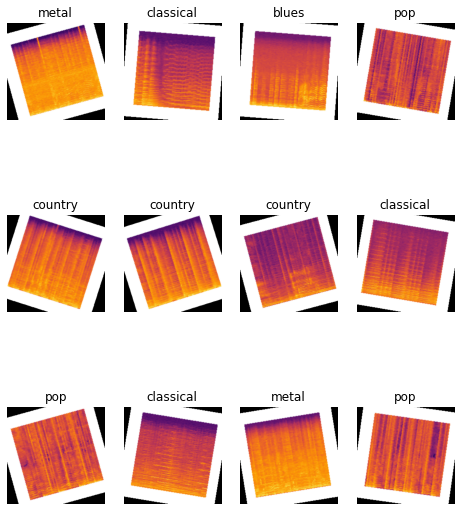

In [27]:
class_plot(train_data)

In [28]:
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [29]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(900, 100)

In [30]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True,  num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

image.shape torch.Size([15, 3, 224, 224])


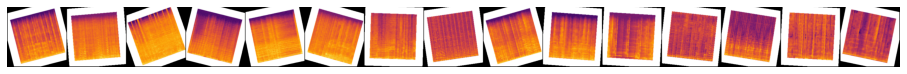

In [31]:
for images, _ in train_dl:
  images = images[:15]
  print(f'image.shape {images.shape}')
  plt.figure(figsize=(16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 15).permute(1, 2, 0))
  break

In [32]:
def accuracy(outputs, labels):
  _,  preds = torch.max(outputs, dim =1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [33]:
class MultilabelImageClassificationBase(nn.Module):

  def training_step(self, batch):
    images, targets = batch
    out = self(images)
    loss = F.cross_entropy(out, targets)
    return loss
  
  def validation_step(self, batch):
    images, targets = batch
    out = self(images)
    loss = F.cross_entropy(out, targets)
    score = accuracy(out, targets)
    return {'val_loss': loss.detach(), 'val_score': score.detach()}
    
  def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
  def epoch_end(self, epoch, result):
       print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [34]:
class Net1(MultilabelImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    nn.Flatten(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    )
  
  def forward(self, xb):
    return self.network(xb)

In [35]:
import torchvision.models as models

class Net(MultilabelImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = models.resnet34(pretrained = True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 10)

  def forward(self, xb):
    return self.network(xb)

  def freeze(self):
    for param in self.network.parameters():
      param.require_grad = False
    for param in self.network.fc.parameters():
      param.require_grad = True
  
  def unfreeze(self):
    for param in self.network.parameters():
      param.require_grad = True


In [36]:
Net()

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [37]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  
  return model.validation_epoch_end(outputs)

In [38]:
@torch.no_grad()
def get_lr(optimizer):
  
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay = 0, grad_clip=None, opt_func= torch.optim.SGD):
  
  torch.cuda.empty_cache()
  history = []
  optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    model.train()
    lrs = []

    for batch in tqdm(train_loader):
      
      loss = model.training_step(batch)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()
      lrs.append(get_lr(optimizer))
      scheduler.step()
      
    result = evaluate(model, val_loader)
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [39]:
device = torch.device('cuda')

def to_device(data):
  if isinstance(data, (list, tuple)):
    return [to_device(x) for x in data]
  return data.to(device, non_blocking = True)

In [ ]:
class DeviceDataLoader():
  def __init__(self, dl):
    self.dl = dl
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b)

  def __len__(self):
    return len(self.dl)

In [41]:
train_dl = DeviceDataLoader(train_dl)
val_dl = DeviceDataLoader(val_dl)

In [42]:
model = to_device(Net())

In [43]:
history = [evaluate(model, val_dl)]

In [44]:
history

[{'val_loss': 2.6602022647857666, 'val_score': 0.0625}]

In [45]:
model.freeze()

In [46]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [47]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip = grad_clip,
                         weight_decay= weight_decay,
                         opt_func = opt_func)

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.8592, val_score: 0.3741


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.8373, val_score: 0.3681


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.3683, val_score: 0.5417


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.3437, val_score: 0.5278


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.2377, val_score: 0.5729
Wall time: 1min 37s


In [48]:
%%time
history += fit_one_cycle(15, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.1448, val_score: 0.6007


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.3313, val_score: 0.5095


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.5999, val_score: 0.4887


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.4599, val_score: 0.5495


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.3467, val_score: 0.5356


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.4604, val_score: 0.4800


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.2145, val_score: 0.5608


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.0995, val_score: 0.5747


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.0927, val_score: 0.6241


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.2412, val_score: 0.6102


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.1095, val_score: 0.6632


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.1623, val_score: 0.6198


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.2163, val_score: 0.6771


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.1850, val_score: 0.6753


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.2477, val_score: 0.6554
Wall time: 4min 44s


In [49]:
model.unfreeze()

In [50]:
%%time
history += fit_one_cycle(50, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.0873, val_score: 0.7049


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.2106, val_score: 0.6693


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.1996, val_score: 0.6398


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.4018, val_score: 0.6354


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.0663, val_score: 0.7188


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.1760, val_score: 0.6042


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.5151, val_score: 0.5981


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.3542, val_score: 0.6476


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.1981, val_score: 0.6615


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.1495, val_score: 0.5825


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.1455, val_score: 0.6259


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.1978, val_score: 0.6615


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.3580, val_score: 0.5842


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.0267, val_score: 0.6415


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.4547, val_score: 0.5573


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.2699, val_score: 0.6589


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.2905, val_score: 0.6415


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.3849, val_score: 0.5920


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.3221, val_score: 0.7049


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.0886, val_score: 0.6892


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.2970, val_score: 0.6649


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.3571, val_score: 0.5825


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.2682, val_score: 0.6736


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.2287, val_score: 0.6892


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.3143, val_score: 0.6337


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.3476, val_score: 0.6988


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.3150, val_score: 0.6693


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [27], val_loss: 1.5868, val_score: 0.6910


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [28], val_loss: 1.1608, val_score: 0.6970


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [29], val_loss: 1.3383, val_score: 0.6970


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.5412, val_score: 0.6771


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.3731, val_score: 0.6953


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [32], val_loss: 1.1613, val_score: 0.7092


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.3848, val_score: 0.6554


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.2743, val_score: 0.7049


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.2778, val_score: 0.7014


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.4001, val_score: 0.7127


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.4478, val_score: 0.6615


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.2621, val_score: 0.7188


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.4296, val_score: 0.6675


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.3034, val_score: 0.7127


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.2537, val_score: 0.7387


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.3758, val_score: 0.7153


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.4073, val_score: 0.7248


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.5703, val_score: 0.7309


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.6147, val_score: 0.6753


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.4479, val_score: 0.7743


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.4682, val_score: 0.7509


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.5452, val_score: 0.7248


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [49], val_loss: 1.6453, val_score: 0.6832
Wall time: 15min 4s


In [51]:
%%time
history += fit_one_cycle(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.5690, val_score: 0.7092


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.4673, val_score: 0.7266


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.4931, val_score: 0.6910


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.6649, val_score: 0.6458


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.5800, val_score: 0.6988


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.6633, val_score: 0.6788


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.6041, val_score: 0.6988


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.7886, val_score: 0.6892


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [8], val_loss: 2.0483, val_score: 0.6493


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.5935, val_score: 0.6814


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.7914, val_score: 0.6120


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.5873, val_score: 0.6970


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.9657, val_score: 0.6536


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.5023, val_score: 0.7127


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.5936, val_score: 0.6675


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.8074, val_score: 0.6571


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.4468, val_score: 0.6832


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.5316, val_score: 0.7049


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.9654, val_score: 0.5903


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.5270, val_score: 0.7049


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.2581, val_score: 0.7266


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.1807, val_score: 0.6832


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.6708, val_score: 0.6675


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.4930, val_score: 0.6224


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.6059, val_score: 0.6597


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.4976, val_score: 0.6719


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.3953, val_score: 0.7066


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [27], val_loss: 1.5190, val_score: 0.6276


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [28], val_loss: 1.8356, val_score: 0.6241


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [29], val_loss: 1.8066, val_score: 0.6319


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.7135, val_score: 0.6710


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.5014, val_score: 0.7049


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [32], val_loss: 1.8495, val_score: 0.6415


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.2740, val_score: 0.7222


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.7098, val_score: 0.6259


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.3262, val_score: 0.6597


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.5255, val_score: 0.7031


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.3938, val_score: 0.6970


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.5012, val_score: 0.6970


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.3642, val_score: 0.6693


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.5438, val_score: 0.6910


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.3777, val_score: 0.6927


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.6527, val_score: 0.6554


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.3744, val_score: 0.6649


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.3798, val_score: 0.7326


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.3580, val_score: 0.7266


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.7423, val_score: 0.6181


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.7913, val_score: 0.6319


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.5655, val_score: 0.6632


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [49], val_loss: 1.4956, val_score: 0.6910


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [50], val_loss: 1.7597, val_score: 0.6780


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [51], val_loss: 1.6884, val_score: 0.6710


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [52], val_loss: 1.8359, val_score: 0.5981


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [53], val_loss: 1.7168, val_score: 0.6927


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [54], val_loss: 1.8014, val_score: 0.6693


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [55], val_loss: 1.7302, val_score: 0.6059


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [56], val_loss: 1.6102, val_score: 0.6198


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [57], val_loss: 1.5600, val_score: 0.6589


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [58], val_loss: 1.2675, val_score: 0.7127


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [59], val_loss: 1.3502, val_score: 0.6892


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [60], val_loss: 1.5717, val_score: 0.6892


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [61], val_loss: 1.5514, val_score: 0.6398


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [62], val_loss: 1.6161, val_score: 0.6953


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [63], val_loss: 1.8111, val_score: 0.6832


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [64], val_loss: 1.7342, val_score: 0.6615


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [65], val_loss: 1.7366, val_score: 0.6415


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [66], val_loss: 1.7932, val_score: 0.6736


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [67], val_loss: 1.6576, val_score: 0.7188


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [68], val_loss: 1.3843, val_score: 0.7465


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [69], val_loss: 1.4727, val_score: 0.6910


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [70], val_loss: 1.3974, val_score: 0.7188


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [71], val_loss: 1.8067, val_score: 0.6693


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [72], val_loss: 1.5974, val_score: 0.7309


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [73], val_loss: 1.5799, val_score: 0.7248


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [74], val_loss: 1.5869, val_score: 0.7387


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [75], val_loss: 1.5686, val_score: 0.7266


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [76], val_loss: 1.5343, val_score: 0.7700


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [77], val_loss: 1.5993, val_score: 0.7465


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [78], val_loss: 1.4901, val_score: 0.7526


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [79], val_loss: 1.4795, val_score: 0.7188


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [80], val_loss: 1.6233, val_score: 0.7109


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [81], val_loss: 1.6967, val_score: 0.7248


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [82], val_loss: 1.6872, val_score: 0.7170


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [83], val_loss: 1.6956, val_score: 0.7543


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [84], val_loss: 1.6509, val_score: 0.6771


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [85], val_loss: 1.6797, val_score: 0.7483


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [86], val_loss: 1.5994, val_score: 0.7483


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [87], val_loss: 1.8496, val_score: 0.6927


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [88], val_loss: 1.8513, val_score: 0.6892


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [89], val_loss: 1.5844, val_score: 0.7405


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [90], val_loss: 1.4444, val_score: 0.7483


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [91], val_loss: 1.5503, val_score: 0.7465


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [92], val_loss: 1.6170, val_score: 0.7049


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [93], val_loss: 1.5006, val_score: 0.7743


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [94], val_loss: 1.5459, val_score: 0.7066


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [95], val_loss: 1.4714, val_score: 0.7700


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [96], val_loss: 1.5707, val_score: 0.7248


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [97], val_loss: 1.4099, val_score: 0.7387


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [98], val_loss: 1.5561, val_score: 0.7543


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [99], val_loss: 1.4908, val_score: 0.6953
Wall time: 24min 50s


In [52]:
!mkdir weights
torch.save(model.state_dict(), './weights/model.pth')